In [1]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import *
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import json
import requests
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
from rasterio.mask import mask
import matplotlib.colors as mcolors
from shapely.geometry import mapping
from shapely.geometry import shape
import folium
from folium.plugins import Fullscreen
from rasterio.transform import from_bounds
import seaborn as sns

In [2]:
# Functions

class Ensemble():
    def __init__(self, models = []):
        self.models = models
        self.accs_dict = None
        self.rocs_dict = None
        self.model_names = [m.__class__.__name__ for m in models]
        self.weights = []
        
    def fit_all(self, X_train, y_train):
        for m in self.models:
            print("Fitting", m.__class__.__name__)
            m.fit(X_train, y_train)
            print(m.__class__.__name__, 'fit.')
        
    
    def evaluate_all(self, X_test, y_true, metric = 'acc'):
        accs = [accuracy_score(y_true, m.predict(X_test)) for m in self.models]
        accs_dict = dict(zip(self.model_names, accs))
        
        
        rocs = [roc_auc_score(y_true, m.predict(X_test)) for m in self.models]
        rocs_dict = dict(zip(self.model_names, rocs))
        
        self.rocs_dict = rocs_dict
        self.accs_dict = accs_dict
        
        if metric == 'acc':
            return accs_dict
        
        return rocs_dict
        
    def get_weights(self):
        return self.rocs_dict
    
    def get_model_names(self):
        return self.model_names
        
# Function that runs the "Drop Column" Feature importance technique 
# I actually have these in a separate .py file which would be much cleaner. 

def make_imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def drop_col(model, X_train, y_train, random_state = 42):
    #Clone the model
    model_clone = clone(model)
    #Reset random state
    model_clone.random_state = random_state
    #Train and score the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    #Store importances
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col,axis=1),y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
        
    importances_df = make_imp_df(X_train.columns, importances)
    return importances_df        
        
def api_call(nas_id, state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results

def sample_multiband_geotiff_with_names(raster_path, gdf):
    """
    Samples a multi-band GeoTIFF at specified point locations from a GeoDataFrame,
    using band names from the raster.

    Parameters:
    - raster_path (str): Path to the GeoTIFF file.
    - gdf (GeoDataFrame): GeoDataFrame containing point geometries.

    Returns:
    - GeoDataFrame with additional columns for each band, using raster band names.
    """

    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Reproject GeoDataFrame to match raster CRS if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Convert point geometries to raster pixel coordinates
        coords = [(geom.x, geom.y) for geom in gdf.geometry]

        # Sample raster at point locations (returns a list of tuples with values per band)
        sampled_values = list(src.sample(coords))

        # Get band names (if available, otherwise use default names)
        band_names = src.descriptions if all(src.descriptions) else [f"band_{i+1}" for i in range(src.count)]

        # Create new columns in the GeoDataFrame with the corresponding band names
        for band_idx, band_name in enumerate(band_names):
            gdf[band_name] = [val[band_idx] for val in sampled_values]

    return gdf

def calculate_metrics_and_plot(conf_matrices):
    sensitivities = []
    specificities = []
    tss_values = []
    
    # Iterate through each confusion matrix
    for cm in conf_matrices:
        TN, FP, FN, TP = cm.ravel()  # Flatten confusion matrix

        sensitivity = TP / (TP + FN)  # Sensitivity (TPR)
        specificity = TN / (TN + FP)  # Specificity (TNR)
        tss = sensitivity + specificity - 1  # True Skill Statistic (TSS)

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        tss_values.append(tss)

    # Compute mean specificity and sensitivity
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    # Plot Boxplot of TSS
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=tss_values, color="skyblue")
    plt.axhline(mean_sensitivity, color="red", linestyle="--", label=f'Mean Sensitivity: {mean_sensitivity:.3f}')
    plt.axhline(mean_specificity, color="green", linestyle="--", label=f'Mean Specificity: {mean_specificity:.3f}')
    plt.ylabel("True Skill Statistic (TSS)")
    plt.title("Boxplot of TSS with Mean Sensitivity & Specificity")
    plt.legend()
    plt.show()

    return sensitivities, specificities, tss_values

def clip_points_with_polygon(points_gdf, polygon_gdf):
    clipped_gdf = points_gdf[points_gdf.geometry.within(polygon_gdf.geometry.union_all())]
    return clipped_gdf

def filter_dataframe_columns(df, feature_choices):
    return df[[col for col in df.columns if col in feature_choices]]

def mark_true(series):
    return [True if feature in series else False for feature in X_train_scaled.columns]

def rename_dict(dictionary, tek_name):
    return_names = []
    return_lists = []
    
    for item in dictionary.items():
        return_names.append(tek_name + str(item[0]))
        return_lists.append(mark_true(list(item[1])))
        
    return dict(zip(return_names, return_lists))
# Function to create empty dictionaries for feature importance
def make_dict():
    return {tup[0]: None for tup in vc_names}

def make_dict_imp():
    return dict(zip([tup[0] for tup in vc_names], [None]))

# Function to append model weights to indv_roc
def append_model_weights(classifiers, X_test_scaled, y_test):
    weights = [accuracy_score(y_test, clf.predict(X_test_scaled)) for clf in classifiers]
    indv_roc.append(weights)
    return weights

def predict_raster_and_display_folium(model, scaler, input_raster, output_raster, feature_list, state_polygon):
    """
    Predicts species presence probability from a raster using a trained model and displays an interactive Folium map.
    
    Parameters:
    - model: Trained machine learning model (supports `predict_proba`)
    - scaler: StandardScaler fitted to training data
    - input_raster: Path to input raster file
    - output_raster: Path to save predicted probability raster
    - feature_list: List of selected feature names (matching band names in the raster)
    - state_polygon: GeoDataFrame containing the state boundary
    """
    # Open the raster file
    with rasterio.open(input_raster) as src:
        profile = src.profile  # Get metadata
        band_names = src.descriptions  # Band names in the raster

        if band_names is None:
            raise ValueError("Raster bands are missing names. Ensure input raster has band descriptions.")

        # Select only the bands that were used in training
        selected_bands_indices = [i for i, band in enumerate(band_names) if band in feature_list]

        if not selected_bands_indices:
            raise ValueError("No matching bands found in the raster for the provided feature list.")

        # Mask raster to the state polygon
        state_geom = [shape(state_polygon.geometry.iloc[0])]
        img_data, transform = mask(src, state_geom, crop=True, nodata=np.nan)

        # Read only the selected bands
        img_data = img_data.astype(float)
        img_data = img_data[selected_bands_indices, :, :]

        # Reshape to 2D (pixels as rows, bands as columns)
        num_bands = len(selected_bands_indices)
        num_pixels = img_data.shape[1] * img_data.shape[2]
        img_reshaped = img_data.reshape(num_bands, num_pixels).T

        # Remove NaN values
        valid_mask = ~np.isnan(img_reshaped).any(axis=1)
        valid_pixels = img_reshaped[valid_mask]

        # Convert to DataFrame with correct feature names
        valid_pixels_df = pd.DataFrame(valid_pixels, columns=[feature_list[i] for i in range(len(selected_bands_indices))])

        # Ensure valid_pixels_scaled remains a DataFrame with correct feature names
        valid_pixels_scaled = pd.DataFrame(scaler.transform(valid_pixels_df), columns=feature_list)
        
        # Now, pass this DataFrame to the model for prediction
        predicted_probs = model.predict_proba(valid_pixels_scaled)[:, 1]


        # Create an empty array for the full image, setting invalid pixels to NaN
        predicted_raster = np.full(img_reshaped.shape[0], np.nan)
        predicted_raster[valid_mask] = predicted_probs

        # Reshape back to original raster shape
        predicted_raster = predicted_raster.reshape(img_data.shape[1], img_data.shape[2])

        # Update metadata for a single-band float output raster
        profile.update(dtype=rasterio.float32, count=1, compress='lzw')

        # Write the predicted probability raster to a new file
        with rasterio.open(output_raster, 'w', **profile) as dst:
            dst.write(predicted_raster.astype(rasterio.float32), 1)

    minx, maxy = transform * (0, 0)  # Upper-left corner
    maxx, miny = transform * (predicted_raster.shape[1], predicted_raster.shape[0])  # Lower-right corner

        
    # Normalize values for visualization (0 to 1)
    normed_raster = (predicted_raster - np.nanmin(predicted_raster)) / (np.nanmax(predicted_raster) - np.nanmin(predicted_raster))

    # Convert to RGB heatmap image
    cmap = plt.get_cmap("jet")  # Use 'jet' colormap
    heatmap_image = (cmap(normed_raster)[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit RGB

    # Flip image vertically because Folium expects north-up orientation
    #heatmap_image = np.flipud(heatmap_image)

    # Create a folium map centered on the raster bounds
    m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=6)

    # Overlay heatmap as an image
    folium.raster_layers.ImageOverlay(
        image=heatmap_image,
        bounds=[[miny, minx], [maxy, maxx]],
        opacity=0.6,
        colormap=lambda x: (x, 0, 1 - x, 1),  # Adjust color mapping
    ).add_to(m)

    # Add fullscreen button
    Fullscreen().add_to(m)

    # Display map in Jupyter Notebook
    return m

In [3]:
#User defined variables

my_state = 'MN' # should be the postal code abbreviation for the state you created the environmental raster for....
my_nas_id = 5 # go to USGS NAS database for species_ids

feature_choices = [
  # 'Freeze_Up',
  # 'Ice_Melt',
  # 'Spawn_Start',
  # 'Spawn_End',
  # 'Spawn_Ideal',
  'Precip_Winter',
  'Precip_Spring',
  'Precip_Summer',
  'Precip_Fall',
  'Flashiness',
  'Runoff',
  'Drawdown',
  'LST_Annual',
  'LST_Summer',
  'LST_Winter',
  'LST_Spring',
  'LST_Fall',
  'NDVI',
  'GPP_Annual',
  'GPP_Summer',
  'Heat_Insolation',
  'Topo_Diversity',
  'gHM',
  'NDTI',
  'NDBI',
  'NDCI',
  'NDSI']

In [4]:
# retrieve occurence data from USGS NAS API
pos_data = api_call(my_nas_id, my_state)
my_data = pos_data[["decimalLatitude", "decimalLongitude"]]
pos_data_gdf = gpd.GeoDataFrame(
    my_data, geometry=gpd.points_from_xy(my_data.decimalLongitude, my_data.decimalLatitude))
#add Coordinate Reference System (CRS)
pos_data_gdf.crs = "EPSG:4326"
bg_data_gdf = gpd.read_file("background.shp")
# Load the GeoTIFF and GeoDataFrame
raster_path = "rsd_all_features.tif" #If you are training in one state and predicting to another change this to your training state raster filename
states_gdf = gpd.read_file("conus_polygon.shp")
state_polygon = states_gdf[states_gdf['STUSPS'] == my_state]
# Sample raster at points
pos_data = sample_multiband_geotiff_with_names(raster_path, pos_data_gdf)
neg_data = sample_multiband_geotiff_with_names(raster_path, bg_data_gdf)
# clip the data to your state
clipped_negs = clip_points_with_polygon(neg_data, state_polygon)
clipped_pos = clip_points_with_polygon(pos_data, state_polygon)

In [5]:
# Sample the environmental data at occurence and background locations
my_pos = filter_dataframe_columns(clipped_pos, feature_choices).dropna().astype(float)
my_negs = filter_dataframe_columns(clipped_negs, feature_choices).dropna().astype(float)
my_pos["Present"], my_negs["Present"] = 1.0, 0.0

In [6]:
# Test model and get weights for feature importance analysis.  This takes a while.  
# Initialize lists for metrics and feature importance
indv_roc = []
vc_roc_arr, vc_cm_arr = [], []
stack_roc_arr, stack_cm_arr = [], []

for x in range(1, 11): 
    print(f"Iteration {x}")
    
    # Splitting positive and negative samples
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        my_pos.drop(columns=['Present']), my_pos["Present"], test_size=0.30, train_size=0.70, random_state=123)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
        my_negs.drop(columns=['Present']), my_negs["Present"], test_size=0.15, train_size=0.25, random_state=123)
    
    # Combine training sets
    X_train = pd.concat([X_train_pos, X_train_neg])
    y_train = pd.concat([y_train_pos, y_train_neg])
    
    # Standardizing the data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test = pd.concat([X_test_pos, X_test_neg])
    X_test_scaled = scaler.transform(X_test)
    y_test = pd.concat([y_test_pos, y_test_neg])
    
    # Define classifiers
    MaxEnt = LogisticRegression(max_iter=10000)
    rf = RandomForestClassifier(n_estimators=1000)
    brt = GradientBoostingClassifier(n_estimators=1000)
    dt = DecisionTreeClassifier()
    mlp = MLPClassifier(max_iter=10000)
    
    # Train classifiers
    classifiers = [MaxEnt, rf, dt, brt, mlp]
    for clf in classifiers:
        clf.fit(X_train_scaled, y_train)
    
    # Append individual model weights
    weights = append_model_weights(classifiers, X_test_scaled, y_test)
    
    # Ensemble Voting Classifier
    vc_names = [('DT', dt), ('MaxEnt', MaxEnt), ('MLP', mlp), ('BRT', brt), ('RF', rf)]
    vc = VotingClassifier(estimators=vc_names, voting='soft', weights=weights)
    vc.fit(X_train_scaled, y_train)
    
     
    # Performance Metrics
    vc_roc = accuracy_score(y_test, vc.predict(X_test_scaled))
    vc_cm = confusion_matrix(y_test, vc.predict(X_test_scaled))
        
    vc_roc_arr.append(vc_roc)
    vc_cm_arr.append(vc_cm)
        


Iteration 1
Iteration 2


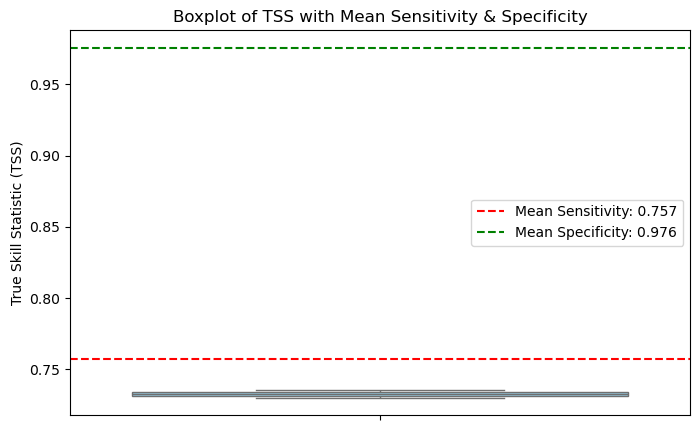

In [7]:
sensitivities, specificities, tss_values = calculate_metrics_and_plot(vc_cm_arr)

In [ ]:
# Calculate average weights for feature importance evaluation
avg_weight = [sum(col) / float(len(col)) for col in zip(*indv_roc)]
vc_imp = VotingClassifier(estimators=vc_names, voting='soft', weights=avg_weight)

# Splitting positive and negative samples
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        my_pos.drop(columns=['Present']), my_pos["Present"], test_size=0.30, train_size=0.70, random_state=123)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
        my_negs.drop(columns=['Present']), my_negs["Present"], test_size=0.15, train_size=0.25, random_state=123)

                  
X_train = pd.concat([X_train_pos, X_train_neg])
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))

y_train = pd.concat([y_train_pos, y_train_neg])

vc_imp.fit(X_train_scaled, y_train)

# Initialize feature importance dictionaries
rfe_dict, perm_dict, drop_dict = make_dict_imp(), make_dict_imp(), make_dict_imp()

for alg in vc_imp.named_estimators:
        dict_name = alg
        clf = vc_imp.named_estimators[dict_name]
        if dict_name == 'MLP':
            continue
        print("Considering", clf)
    
        # Recursive Feature Elimination (RFE)
        rfe_selector = RFECV(estimator=clf, min_features_to_select=3, step=1)
        rfe_selector.fit(X_train_scaled, y_train)
        rfe_support = rfe_selector.get_support()
        rfe_features = X_train_scaled.loc[:,rfe_support].columns.tolist()
        rfe_dict[dict_name] = rfe_features
        # Permutation Importance
        perm_imp = permutation_importance(clf, X_train_scaled, y_train)
        perm_imp['feature'] = X_train_scaled.columns
        perm_features = pd.DataFrame(perm_imp['feature'],perm_imp['importances_mean'],columns = ['Feature']) \
                        .sort_index(ascending=False)['Feature'].values[:3]
        perm_dict[dict_name] = perm_features
        # Drop Column Importance (Assuming a predefined drop_col function)
        drop_dict_list = []
        
        drop_col_feats = drop_col(clf, X_train_scaled, y_train) #, random_state = 10)
        drop_col_three = drop_col_feats.sort_values('feature_importance',ascending = False)['feature'][:3]
        drop_dict[dict_name] = drop_col_three
    
print("Feature importance evaluation completed.")


#We end up with a dataframe that says, for any model / feature importance technique, whether or not a feature ended up in the top N (i.e. whether or not that feature is important).
features_df = pd.concat([pd.DataFrame(rename_dict(perm_dict,'PERM_')).reset_index(drop=True),
                        pd.DataFrame(rename_dict(rfe_dict,'RFE_')),
                        pd.DataFrame(rename_dict(drop_dict, 'DROP_'))],axis=1)

features_df['Total'] = np.sum(features_df, axis=1)
features_df['Feature'] = X_train.columns
features_df.sort_values(['Total','Feature'] , ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(8,4))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )

# plt.xticks(rotation=75)
plt.bar(features_df['Feature'], features_df['Total'])
plt.title("Variable importances")
plt.ylabel("Number of times a variable appeared in top 3")

Considering DecisionTreeClassifier()
Considering LogisticRegression(max_iter=10000)
Considering GradientBoostingClassifier(n_estimators=1000)


In [ ]:
# Add steps to train from one state and predict to state without presences.

In [ ]:
# Create heatmap with all data
X_train_pos = my_pos.drop(columns=['Present'])
y_train_pos = my_pos['Present']
X_train_neg = my_negs.drop(columns=['Present'])
y_train_neg = my_negs['Present']

X_train = pd.concat([X_train_pos, X_train_neg])
scaler_heatmap = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_heatmap.transform(X_train), columns=X_train.columns)

y_train = pd.concat([y_train_pos, y_train_neg])

MaxEnt = LogisticRegression(max_iter = 10000)
rf = RandomForestClassifier(n_estimators=1000)
brt = GradientBoostingClassifier(n_estimators=1000)
dt = DecisionTreeClassifier()
mlp = MLPClassifier(max_iter = 10000)

# Individual Confusion Matrices
MaxEnt.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled,y_train)
dt.fit(X_train_scaled, y_train)
brt.fit(X_train_scaled, y_train) 
mlp.fit(X_train_scaled, y_train)                    
########################################################################################################
#Ensemble 
ensemble_vc = Ensemble([dt, MaxEnt, rf, brt, mlp]) 
ensemble_vc.fit_all(X_train_scaled, y_train)
weights = ensemble_vc.get_weights()
vc_names = [('DT', dt), ('MaxEnt', MaxEnt), ('MLP', mlp), ('BRT', brt), ('RF', rf)]
vc_heatmaps = VotingClassifier(estimators=vc_names, voting='soft', weights = weights)
vc_heatmaps.fit(X_train_scaled, y_train)


In [ ]:
# Run prediction and display the heatmap
output_tif = "predicted_probabilities.tif"
predict_to_raster = raster_path # If you made a second raster for your state to predict to.  Define it here.

# Define the selected feature list (only include features you want to use)
selected_features = X_train.columns.tolist()

m = predict_raster_and_display_folium(vc_heatmaps, scaler_heatmap, predict_to_raster, output_tif, selected_features, state_polygon)
m  # This will display the interactive map in Jupyter